In [1]:
import random
import numpy as np

import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")

import keras
print(f"Keras Version: {keras.__version__}")


# gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# List physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth and limit memory usage
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])  # Memory limit in MB
    except RuntimeError as e:
        print(e)

# Now you can create your session or model
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto())

2024-06-07 23:45:56.386820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 23:45:56.386912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 23:45:56.529779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version: 2.15.0
Keras Version: 3.3.3


In [2]:
seed = 875
no_of_epoch=150
# Set random seeds
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"SEED: {seed}")

SEED: 875


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization

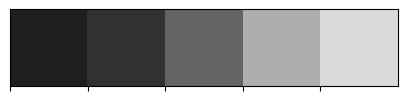

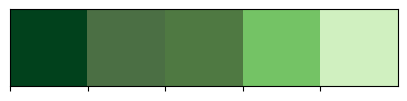

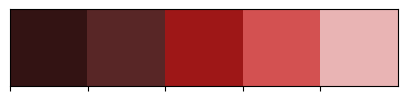

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [5]:
import os
DIRECTORY= r"/kaggle/input/api-rpd/Pest_V2"

def find_Class(directory_path):
    if not os.path.exists(directory_path):
        raise ValueError(f"The directory '{directory_path}' does not exist.")
    if not os.path.isdir(directory_path):
        raise ValueError(f"The path '{directory_path}' is not a directory.")
    
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Filter out only directories
    folders = [entry for entry in all_entries if os.path.isdir(os.path.join(directory_path, entry))]
    
    return folders



CATAGORIES= []
try:
    folders = find_Class(DIRECTORY)
    print(f"Directories in '{DIRECTORY}':")
    for folder in folders:
        CATAGORIES.append(folder)
except ValueError as e:
    print(e)

CATAGORIES

Directories in '/kaggle/input/api-rpd/Pest_V2':


['paddy stem maggot',
 'rice leafhopper',
 'rice gall midge',
 'brown plant hopper',
 'rice leaf caterpillar',
 'small brown plant hopper',
 'rice water weevil',
 'yellow rice borer',
 'asiatic rice borer',
 'rice leaf roller']

In [6]:
labels =CATAGORIES
labels

['paddy stem maggot',
 'rice leafhopper',
 'rice gall midge',
 'brown plant hopper',
 'rice leaf caterpillar',
 'small brown plant hopper',
 'rice water weevil',
 'yellow rice borer',
 'asiatic rice borer',
 'rice leaf roller']

In [7]:
import shutil

train_dir = '/kaggle/input/api-rpd/Pest_V2'

# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(train_dir)
print(subdirectories)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.2, random_state=42)

# Create directories for training and validation data
train_data_dir = 'path/to/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = 'path/to/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to the corresponding directories
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(train_dir, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.3, random_state=42)

    for filename in train_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
        
print("*****Done*****")

['paddy stem maggot', 'rice leafhopper', 'rice gall midge', 'brown plant hopper', 'rice leaf caterpillar', 'small brown plant hopper', 'rice water weevil', 'yellow rice borer', 'asiatic rice borer', 'rice leaf roller']
*****Done*****


In [8]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join(train_data_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(validation_data_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 215/215 [00:00<00:00, 1085.58it/s]


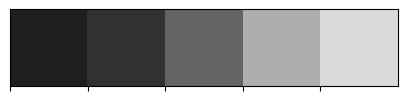

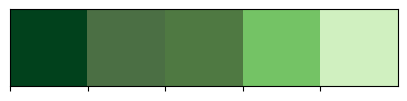

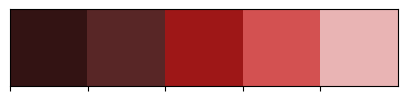

In [9]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

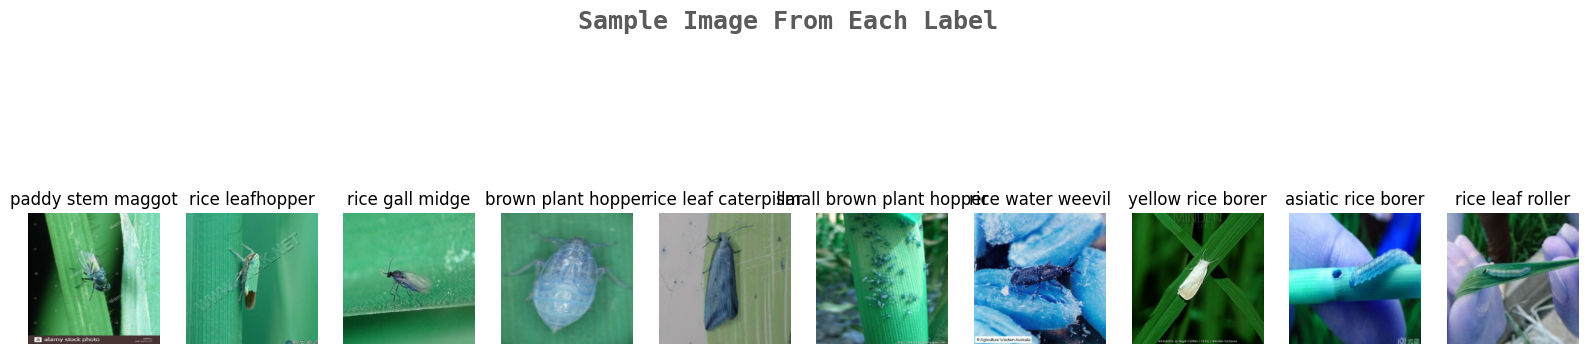

In [10]:
k=0
fig, ax = plt.subplots(1,10,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [11]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [12]:
X_train.shape

(3156, 224, 224, 3)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, 
                                                 test_size=0.1,random_state=101)

In [14]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,
                        input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(len(labels),activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 4,020,358 (15.34 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [17]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer = optimizer, metrics= ['accuracy'])

In [18]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = np.sqrt(.1), patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1,min_lr=0.0000001)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)
callbacks=[tensorboard,checkpoint,reduce_lr,earlystop]

In [19]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =no_of_epoch, verbose=1, batch_size=32,
                   callbacks=callbacks)

Epoch 1/150


I0000 00:00:1717804086.222195      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717804086.330373      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.1645 - loss: 2.3192

W0000 00:00:1717804160.180563      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717804166.681366      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.46479, saving model to effnet.keras


W0000 00:00:1717804170.711071      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.1653 - loss: 2.3177 - val_accuracy: 0.4648 - val_loss: 1.8659 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4428 - loss: 1.7644
Epoch 2: val_accuracy improved from 0.46479 to 0.62324, saving model to effnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.4432 - loss: 1.7638 - val_accuracy: 0.6232 - val_loss: 1.4512 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5921 - loss: 1.4323
Epoch 3: val_accuracy improved from 0.62324 to 0.69366, saving model to effnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.5921 - loss: 1.4320 - val_accuracy: 0.6937 - val_loss: 1.1997 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6912 - loss: 1.1794
Epoch 4: val_accuracy improved from 0.69366 to 0.73592, saving model to effnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accu

In [20]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

W0000 00:00:1717804631.258892      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 673ms/step


W0000 00:00:1717804637.318856      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [21]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.80      0.80      0.80        20
           2       1.00      0.97      0.98        32
           3       0.71      0.76      0.74        33
           4       0.75      0.46      0.57        13
           5       0.59      0.53      0.56        19
           6       0.94      1.00      0.97        44
           7       0.90      0.78      0.84        23
           8       0.89      0.85      0.87        55
           9       0.87      1.00      0.93        67

    accuracy                           0.86       316
   macro avg       0.84      0.80      0.81       316
weighted avg       0.86      0.86      0.86       316



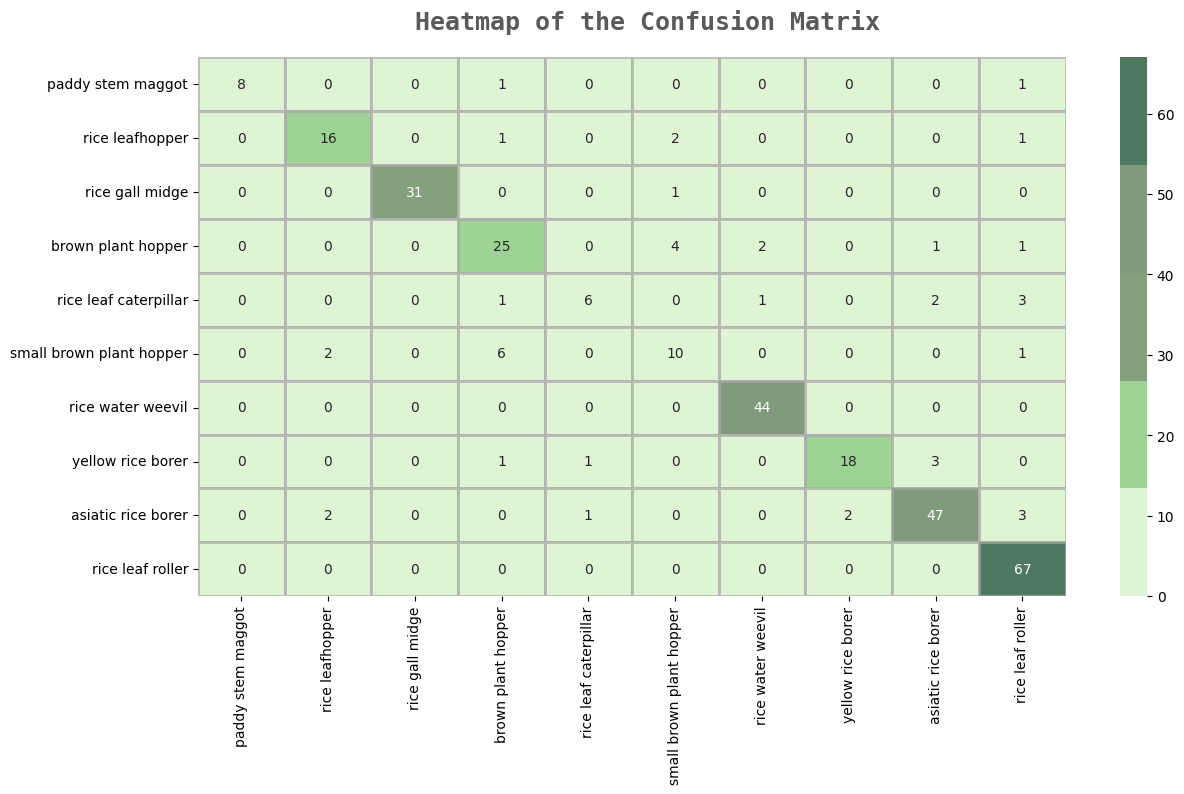

In [22]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

# InceptionV3

In [23]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers

from keras.models import Model, Sequential
from keras import layers

In [24]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(image_size,image_size,3))
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False
    

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(labels), activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005), 
    metrics=['accuracy']
)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 394,880 (1.51 MB)

 Non-trainable params: 21,407,904 (81.66 MB)

In [25]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer = optimizer, metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("Inception.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = np.sqrt(.1), patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1,min_lr=0.0000001)


history = model.fit(X_train,y_train,validation_split=0.1, epochs =no_of_epoch, verbose=1, batch_size=32,
                   callbacks=callbacks)

Epoch 1/150


W0000 00:00:1717804674.093220      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.2364 - loss: 3.1626

W0000 00:00:1717804702.510835      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 410ms/step - accuracy: 0.2367 - loss: 3.1556 - val_accuracy: 0.2993 - val_loss: 2.1257 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4521 - loss: 1.6071
Epoch 2: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.4522 - loss: 1.6073 - val_accuracy: 0.3873 - val_loss: 1.8918 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5996 - loss: 1.2254
Epoch 3: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.5996 - loss: 1.2258 - val_accuracy: 0.4437 - val_loss: 1.7974 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7091 - loss: 0.9852
Epoch 4: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7090 - loss: 0.9857 - val_accuracy: 0.4542 - val_

In [26]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

W0000 00:00:1717804829.514658      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 679ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.27      0.20      0.23        20
           2       0.33      0.03      0.06        32
           3       0.15      0.12      0.14        33
           4       0.50      0.15      0.24        13
           5       0.13      0.11      0.12        19
           6       0.32      0.18      0.23        44
           7       0.35      0.26      0.30        23
           8       0.21      0.49      0.30        55
           9       0.35      0.43      0.38        67

    accuracy                           0.26       316
   macro avg       0.26      0.20      0.20       316
weighted avg       0.28      0.26      0.24       316



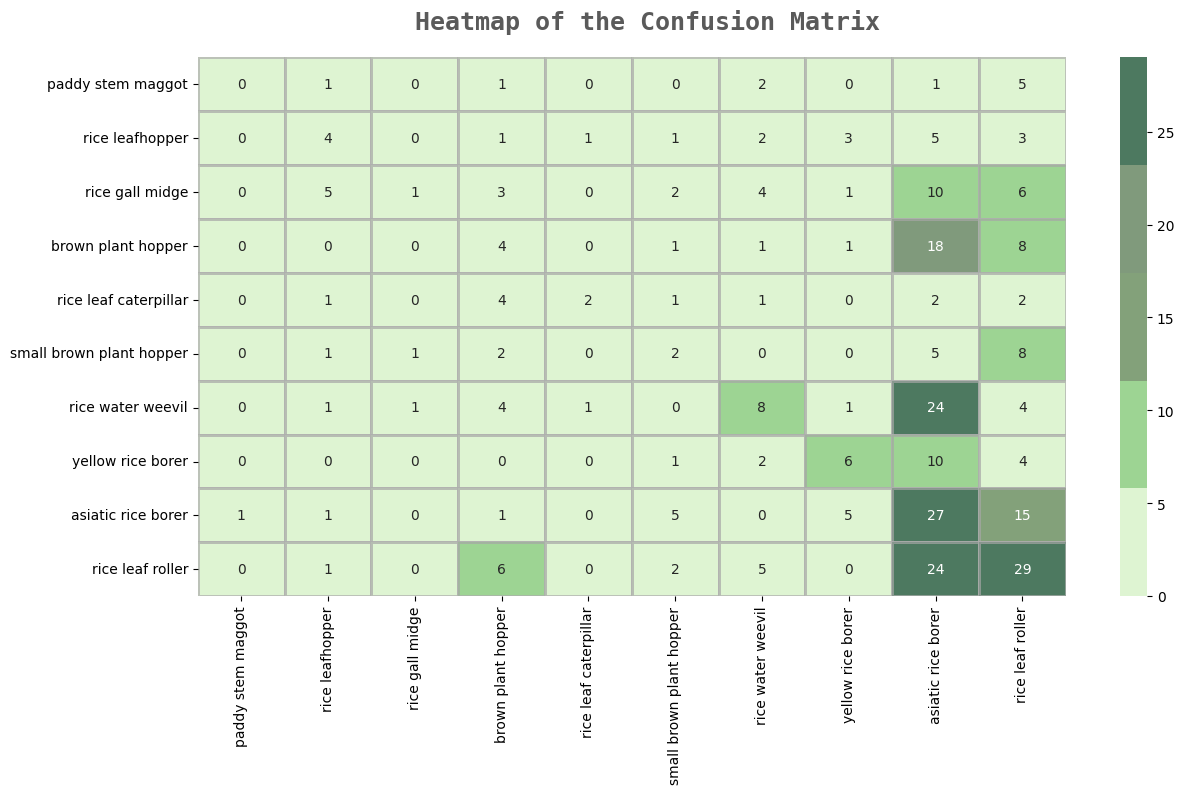

In [27]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [28]:
base_model =InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3), pooling='max')
x = base_model.output
BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(labels), activation='softmax', kernel_regularizer=l2(0.001))(x)  # L2 regularization
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer = optimizer, metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("Inception2.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = np.sqrt(.1), patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1,min_lr=0.0000001)


history = model.fit(X_train,y_train,validation_split=0.1, epochs =no_of_epoch, verbose=1, batch_size=32,
                   callbacks=callbacks)

Epoch 1/150


W0000 00:00:1717804931.990676      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.2384 - loss: 3.2611

W0000 00:00:1717805003.335509      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.2393 - loss: 3.2531

W0000 00:00:1717805009.786102      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy did not improve from 0.88028


W0000 00:00:1717805013.873369      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2400 - loss: 3.2452 - val_accuracy: 0.4225 - val_loss: 1.9428 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6412 - loss: 1.3833
Epoch 2: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.6413 - loss: 1.3828 - val_accuracy: 0.6127 - val_loss: 1.4635 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8346 - loss: 0.8458
Epoch 3: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.8344 - loss: 0.8461 - val_accuracy: 0.6655 - val_loss: 1.3150 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9113 - loss: 0.6251
Epoch 4: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - accuracy: 0.9112 - loss: 0.6251 - val_accuracy: 0.6761 - val_loss: 1.2545 - learning_rate: 1.0000e-04
Epoc

In [30]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

W0000 00:00:1717805395.734425      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 683ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.30      0.15      0.20        20
           2       0.64      0.22      0.33        32
           3       0.19      0.12      0.15        33
           4       0.36      0.31      0.33        13
           5       0.14      0.16      0.15        19
           6       0.65      0.70      0.67        44
           7       0.17      0.13      0.15        23
           8       0.45      0.47      0.46        55
           9       0.44      0.76      0.56        67

    accuracy                           0.42       316
   macro avg       0.33      0.30      0.30       316
weighted avg       0.40      0.42      0.39       316



W0000 00:00:1717805401.883252      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# InceptionResNetV2

In [31]:
base_model = InceptionResNetV2(weights='imagenet',
    include_top=False,
    input_shape=(image_size,image_size,3))
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False
    

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(labels), activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005), 
    metrics=['accuracy']
)

model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 4,831,424 (18.43 MB)

 Non-trainable params: 49,505,312 (188.85 MB)

In [32]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer = optimizer, metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("InceptionResnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = np.sqrt(.1), patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1,min_lr=0.0000001)


history = model.fit(X_train,y_train,validation_split=0.1, epochs =no_of_epoch, verbose=1, batch_size=32,
                   callbacks=callbacks)

Epoch 1/150


W0000 00:00:1717805458.830373      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.2397 - loss: 2.2331

W0000 00:00:1717805504.625207      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 96s 674ms/step - accuracy: 0.2400 - loss: 2.2320 - val_accuracy: 0.2148 - val_loss: 2.1620 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3271 - loss: 1.9801
Epoch 2: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.3271 - loss: 1.9801 - val_accuracy: 0.3169 - val_loss: 2.0073 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3505 - loss: 1.8982
Epoch 3: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.3505 - loss: 1.8983 - val_accuracy: 0.3415 - val_loss: 1.9447 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3778 - loss: 1.8256
Epoch 4: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.3778 - loss: 1.8257 - val_accuracy: 0.34

In [33]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 

W0000 00:00:1717805792.477908      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        20
           2       0.36      0.25      0.30        32
           3       0.10      0.09      0.10        33
           4       0.20      0.23      0.21        13
           5       0.06      0.21      0.09        19
           6       0.33      0.07      0.11        44
           7       0.33      0.13      0.19        23
           8       0.25      0.42      0.31        55
           9       0.33      0.34      0.34        67

    accuracy                           0.22       316
   macro avg       0.20      0.17      0.16       316
weighted avg       0.24      0.22      0.21       316



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


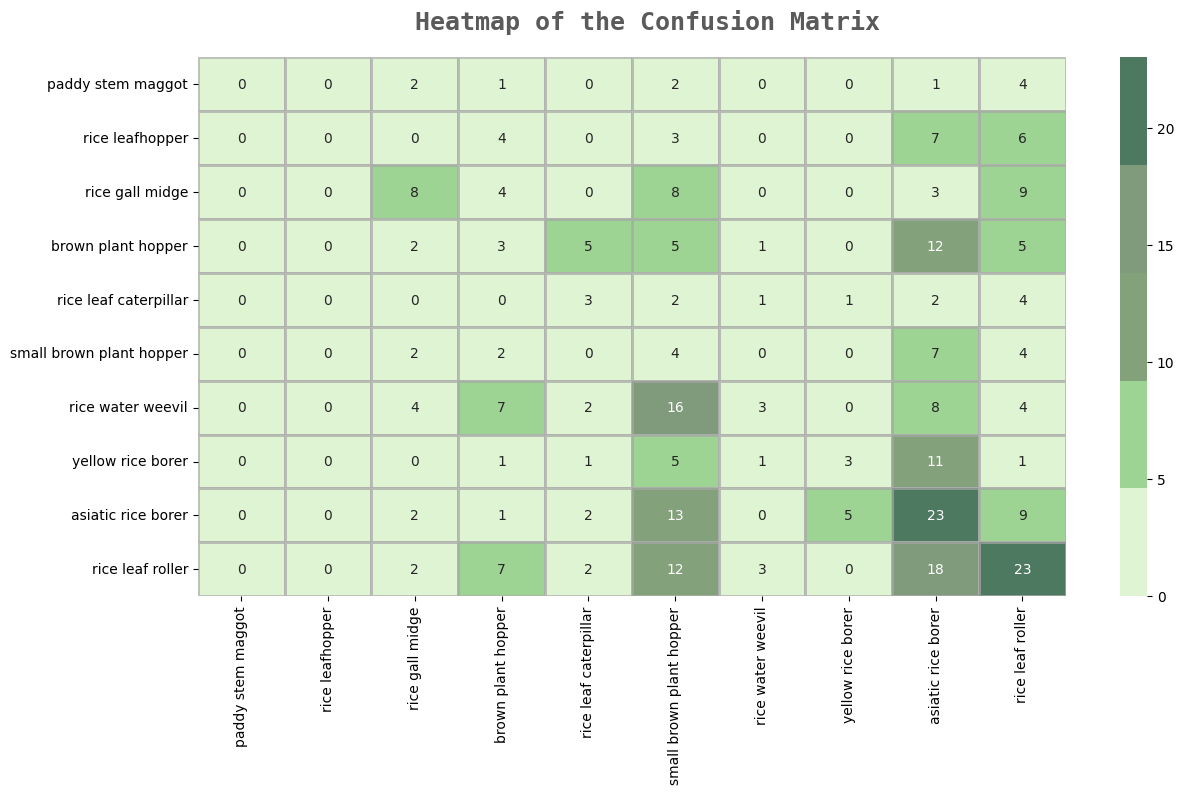

In [34]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [35]:
base_model =InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3), pooling='max')
x = base_model.output
BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(labels), activation='softmax', kernel_regularizer=l2(0.001))(x)  # L2 regularization
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer = optimizer, metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("InceptionResNetV2.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = np.sqrt(.1), patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1,min_lr=0.0000001)


history = model.fit(X_train,y_train,validation_split=0.1, epochs =no_of_epoch, verbose=1, batch_size=32,
                   callbacks=callbacks)

Epoch 1/150


W0000 00:00:1717805999.497429      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.2508 - loss: 3.1492

W0000 00:00:1717806140.203170      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2518 - loss: 3.1414   

W0000 00:00:1717806153.143987      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy did not improve from 0.88028


W0000 00:00:1717806160.875116      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.2528 - loss: 3.1339 - val_accuracy: 0.5810 - val_loss: 1.5845 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6367 - loss: 1.4075
Epoch 2: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 579ms/step - accuracy: 0.6370 - loss: 1.4066 - val_accuracy: 0.7183 - val_loss: 1.2741 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7909 - loss: 0.9415
Epoch 3: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 557ms/step - accuracy: 0.7910 - loss: 0.9413 - val_accuracy: 0.7430 - val_loss: 1.1575 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8698 - loss: 0.7056
Epoch 4: val_accuracy did not improve from 0.88028
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 566ms/step - accuracy: 0.8699 - loss: 0.7054 - val_accuracy: 0.7711 - val_loss: 1.1150 - learning_rate: 1.0000e-04
Epoc

In [37]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step 

W0000 00:00:1717807070.139899      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.38      0.80      0.52        20
           2       0.87      0.41      0.55        32
           3       0.32      0.21      0.25        33
           4       0.00      0.00      0.00        13
           5       0.24      0.21      0.22        19
           6       0.78      0.80      0.79        44
           7       0.54      0.30      0.39        23
           8       0.54      0.65      0.59        55
           9       0.64      0.81      0.71        67

    accuracy                           0.56       316
   macro avg       0.50      0.48      0.47       316
weighted avg       0.56      0.56      0.54       316



W0000 00:00:1717807083.344451      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


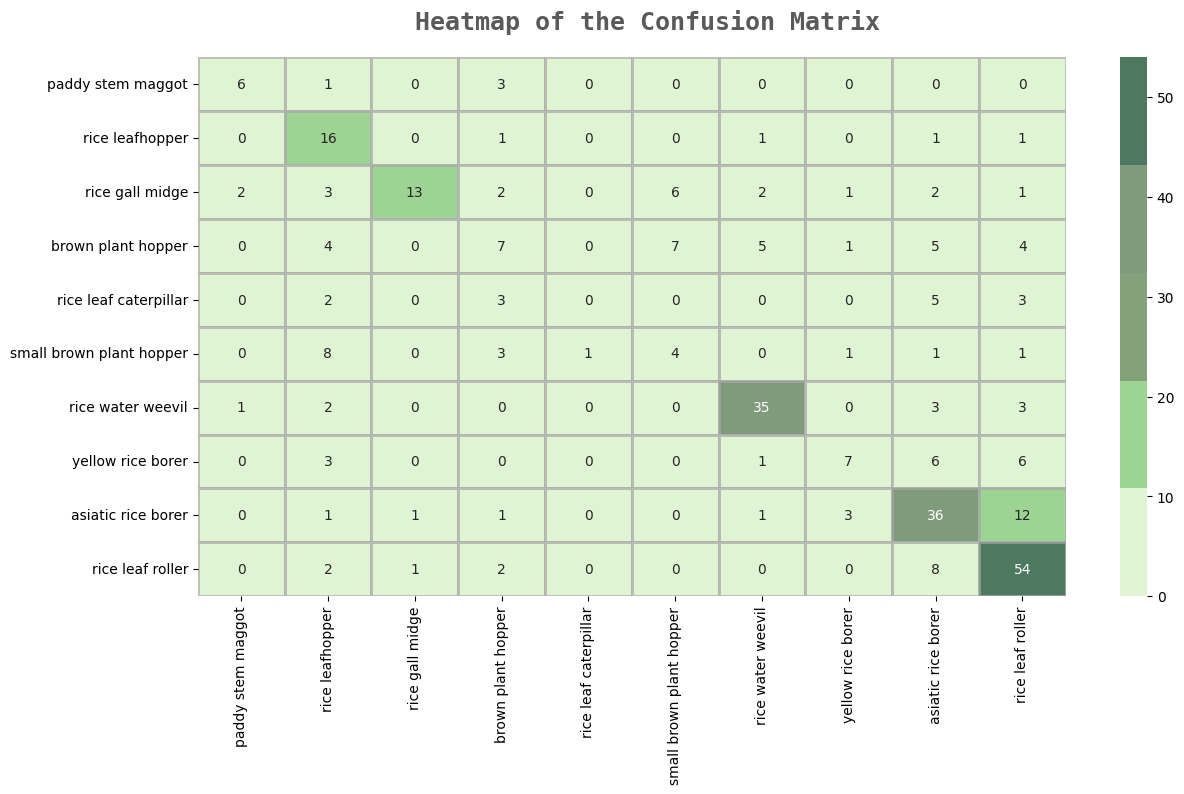

In [38]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()